In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import os

# Paths (adjust as needed)
SC_PARQUET   = "../../data/processed/breast_sc_log1pCP10k__symbols_mapped.parquet"
BULK_PARQUET = "../../data/processed/voom_matrix_HVGsdGMM_top3000.parquet"  # your bulk file

OUTDIR = "hvg_analysis_outputs"
os.makedirs(OUTDIR, exist_ok=True)

EPS = 1e-12


In [3]:
# Load single-cell expression matrix (cells × genes)
X_sc = pd.read_parquet(SC_PARQUET)
print("Single-cell matrix shape:", X_sc.shape)


Single-cell matrix shape: (35276, 47022)


In [4]:
# Compute SD across cells for each gene
sd_sc = X_sc.std(axis=0)
print(sd_sc.describe())


count    47022.000000
mean         0.115696
std          0.172638
min          0.000248
25%          0.009894
50%          0.031388
75%          0.146232
max          1.863092
dtype: float64


In [5]:
# Prepare values
logsd = np.log10(sd_sc.values + EPS).reshape(-1, 1)

# Fit 2-component GMM
gmm = GaussianMixture(n_components=2, random_state=42).fit(logsd)
means = gmm.means_.flatten()
weights = gmm.weights_.flatten()
hi_comp = int(np.argmax(means))

# Assign genes
comp_assign = gmm.predict(logsd)
sc_hvg_candidates = sd_sc.index[comp_assign == hi_comp]

print("GMM means:", means, "weights:", weights)
print("High-variance genes (before cutoff):", len(sc_hvg_candidates))


GMM means: [-0.74076002 -1.91213576] weights: [0.40905401 0.59094599]
High-variance genes (before cutoff): 18776


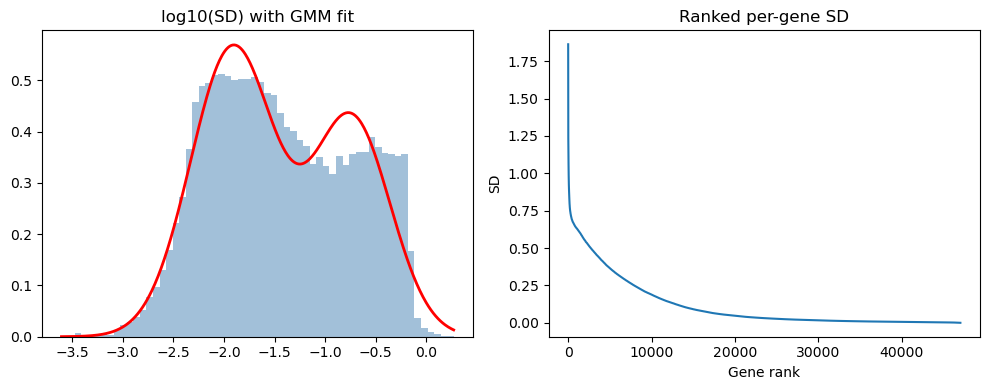

In [6]:
# Histogram with GMM curves
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Histogram of log10 SD
ax[0].hist(logsd, bins=60, density=True, alpha=0.5, color="steelblue")
xs = np.linspace(logsd.min(), logsd.max(), 500).reshape(-1,1)
pdf = np.exp(gmm.score_samples(xs))
ax[0].plot(xs, pdf, 'r-', lw=2)
ax[0].set_title("log10(SD) with GMM fit")

# Elbow curve
sd_sorted = sd_sc.sort_values(ascending=False).values
ax[1].plot(np.arange(1, len(sd_sorted)+1), sd_sorted)
ax[1].set_xlabel("Gene rank")
ax[1].set_ylabel("SD")
ax[1].set_title("Ranked per-gene SD")

plt.tight_layout()
plt.show()


In [7]:
# Choose a cap for HVGs (e.g. 3000–5000 for scRNA-seq)
CAP_TOP_K = 5000

# Sort HVG candidates by SD and keep top K
sc_hvgs = sd_sc.loc[sc_hvg_candidates].sort_values(ascending=False).head(CAP_TOP_K).index.tolist()

print("Selected HVGs:", len(sc_hvgs))
pd.Series(sc_hvgs, name="gene").to_csv(os.path.join(OUTDIR, f"sc_HVGs_top{CAP_TOP_K}.csv"), index=False)


Selected HVGs: 5000


SD cutoff value: 0.3651 (log10=-0.44)


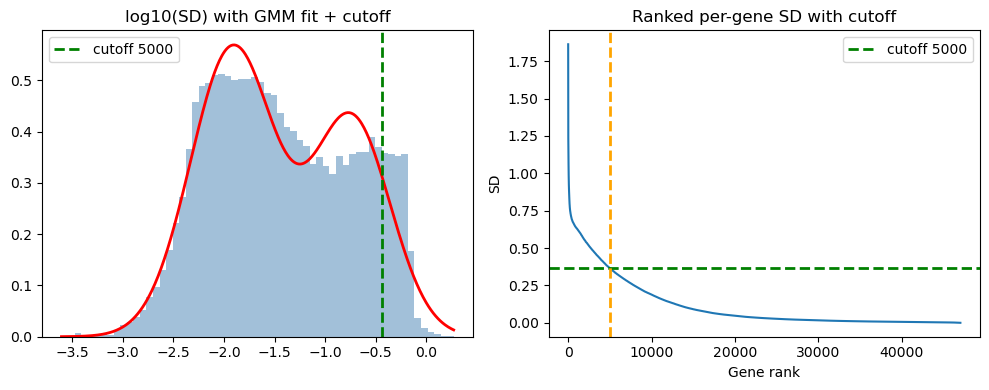

: 

In [ ]:
# Suppose you already computed sc_hvgs = top 5000 by SD
CAP_TOP_K = 5000

# Get the SD threshold for the CAP_TOP_K cutoff
sd_sorted = sd_sc.sort_values(ascending=False)
sd_cut = sd_sorted.iloc[CAP_TOP_K-1]
log_cut = np.log10(sd_cut + EPS)

print(f"SD cutoff value: {sd_cut:.4f} (log10={log_cut:.2f})")

# Redraw plots with cutoff lines
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Histogram with cutoff
ax[0].hist(logsd, bins=60, density=True, alpha=0.5, color="steelblue")
xs = np.linspace(logsd.min(), logsd.max(), 500).reshape(-1,1)
pdf = np.exp(gmm.score_samples(xs))
ax[0].plot(xs, pdf, 'r-', lw=2)
ax[0].axvline(log_cut, color="green", linestyle="--", lw=2, label=f"cutoff {CAP_TOP_K}")
ax[0].set_title("log10(SD) with GMM fit + cutoff")
ax[0].legend()

# Ranked SD curve with cutoff
ax[1].plot(np.arange(1, len(sd_sorted)+1), sd_sorted)
ax[1].axhline(sd_cut, color="green", linestyle="--", lw=2, label=f"cutoff {CAP_TOP_K}")
ax[1].axvline(CAP_TOP_K, color="orange", linestyle="--", lw=2)
ax[1].set_xlabel("Gene rank")
ax[1].set_ylabel("SD")
ax[1].set_title("Ranked per-gene SD with cutoff")
ax[1].legend()

plt.tight_layout()
plt.show()
